### Project 3

Refer to the project writeup [here](https://rutgers.app.box.com/s/k5jsawk0jwsprkcha0z2n2tli3pv53l7)


In [128]:
#first create a sample training image. Then worry about how to classify it
#can we use the same training set from task 1 for task 2, provided it's classified correctly
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap, BoundaryNorm

# import xlsxwriter

In [129]:
class diagram:
    def __init__(self, data):
        self.data = data #this will be a 20x20 matrix

    @classmethod
    def createDiagram(cls):
        dgrm = cls(np.zeros((20,20), dtype=float))
        return dgrm
    
    def layWires(self):
        possibleRows = [i for i in range(self.data.shape[0])] 
        possibleColumns = [i for i in range(self.data.shape[1])]

        colors = [1,2,3,4] #1 is red, 2 is blue, 3 is yellow, 4 is green
        layRowFirst = random.randrange(2) #0 indicates false, 1 indicates true
        dangerous = 0 #boolean to keep track of whether the diagram is dangerous. #0 means not dangerous, 1 meeans it is dangerous
        thirdWireLaid = 0 #this will hold the color of the 3rd wire laid down
        for i in range(4):
            color = colors.pop(random.randrange(len(colors)))
            
            #if the wire to be laid is yellow and the red wire is already laid, mark diagram as dangerous
            if color == 3 and (1 not in colors): dangerous = 1
            
            if i==2: thirdWireLaid = color
            if i%2 == 0:
                if layRowFirst == 1:
                    row = possibleRows.pop(random.randrange(len(possibleRows)))
                    for j in range(self.data.shape[0]): self.data[row][j] = color
                else:
                    col = possibleColumns.pop(random.randrange(len(possibleColumns)))
                    for j in range(self.data.shape[1]): self.data[j][col] = color
            else:
                if layRowFirst == 1:
                    col = possibleColumns.pop(random.randrange(len(possibleColumns)))
                    for j in range(self.data.shape[1]): self.data[j][col] = color
                else:
                    row = possibleRows.pop(random.randrange(len(possibleRows)))
                    for j in range(self.data.shape[0]): self.data[row][j] = color
        
        return (dangerous,0) if dangerous == 0 else (dangerous,thirdWireLaid)


    def showDiagram(self):
        colors = ['white', 'red', 'blue', 'yellow','green']
        custom_map = ListedColormap(colors)
        bounds = [-.1, .5, 1.5, 2.5, 3.5, 4.5]
        norm = BoundaryNorm(bounds, custom_map.N)
        plt.imshow(self.data, cmap = custom_map, norm=norm)
        
        #Ensure shows plot with increments of 1
        plt.xticks(np.arange(-0.5, self.data.shape[1], 1), labels=[])
        plt.yticks(np.arange(-0.5, self.data.shape[0], 1), labels=[])

        #Show gridlines 
        plt.grid(True)

        #Show colorbar
        plt.colorbar()
        plt.show()

dgrm = diagram.createDiagram()
dgrm.layWires()
dgrm.showDiagram()


(1, 3)

In [130]:
data = np.load('1k_data/data.npy')
labels = np.load('1k_data/labels.npy')

dgrm = diagram(data[0].reshape((20,20)))
# dgrm.showDiagram()

In [131]:
# np.random.seed(42)
def SGD(w, x, y, alpha):
    # compute estimated output y'
    y_prime = sigmoid(float(np.dot(x,w)))
    # compute Loss of y' compared to y where y is the actual/correct output
    cur_loss = loss(y, y_prime) + (1e-10 * np.sum(np.abs(w))) # l2 reg can be changed for the model
    # SGD with new weights = old weights - alpha (sig(w * x) - y)xi) 
    w -= alpha * (y_prime - y) * x
    return cur_loss

def sigmoid(z):
    return (1 / (1 + np.exp(-z)))

def avg_loss(data, w, labels):
    losses = [loss(sigmoid(np.dot(x, w)), y) for x, y in zip(data, labels[:, 0])]
    return np.average(losses)

def accuracy(data, labels, weights):
    outs = np.dot(data, weights)
    binary = (outs >= 0.5).astype(int)

    samples = data.shape[0]
    correct = sum(binary == labels[:,0])
    return correct/samples


def loss(actual_y, y_prime):
    epsilon = 1e-15
    return -actual_y * np.log(y_prime+epsilon) - (1-actual_y) * np.log(1-y_prime+epsilon)

def add_polynomial_features(X, degree):
    """Add polynomial features to the input data."""
    features = [X]
    for d in range(2, degree + 1):
        features.append(X**d)
    return np.column_stack(features)


In [132]:
def feed_forward(data,labels, num_iters = 10000):
    data = np.column_stack([data, np.ones(data.shape[0])]) # Adding in a bias term
    samples,features = data.shape
    w = np.random.rand(features)*2 - np.ones(shape=features) #[0,1] -> [-100,100]
    loss_coords, accuracy_coords = [], []
    for i in range(num_iters):
        index = np.random.randint(0, 1000)
        x = data[index]
        y = labels[index][0]
        loss = SGD(w, x, y, alpha=0.01)
        loss_coords.append(avg_loss(data,w,labels))
        accuracy_coords.append(accuracy(data,labels,w))
          
    print(f'Average Loss: {avg_loss(data,w,labels)}, Accuracy on testing set: {accuracy(data, labels, w)}')
    return (loss_coords, accuracy_coords)

# _, _ = feed_forward(data,labels)



In [133]:
# Now let's play around with adding non-linear features from our input space
new_inp = add_polynomial_features(data,4)
# _, _ = feed_forward(new_inp,labels,num_iters=20000)

In [134]:
with_sin = np.column_stack([data,])
# _, _ = feed_forward(with_sin,labels,num_iters=20000)

In [135]:
def compute_neighborhood_mean(data, window_size):
    image = data.reshape((20,20))
    padded_image = np.pad(image, pad_width=window_size//2, mode='constant')

    neighborhood_means = np.zeros_like(image, dtype=np.float64)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            neighborhood = padded_image[i:i+window_size, j:j+window_size]
            neighborhood_means[i, j] = np.mean(neighborhood)

    return neighborhood_means

def compute_neighborhood_mean2(image, window_size):
    image = image.reshape((20,20))
    
    padded_image = np.pad(image, pad_width=window_size//2, mode='constant')

    windowed_view = np.lib.stride_tricks.sliding_window_view(padded_image, (window_size, window_size))

    neighborhood_means = np.mean(windowed_view, axis=(-2, -1))

    return neighborhood_means



In [136]:
# %%timeit
# means = compute_neighborhood_mean2(data[0], 3)

In [137]:
# %%timeit
# means1 = compute_neighborhood_mean(data[0],3)

In [138]:
def add_neighborhood_feature(data, window_size=3):
    new_data = [] # store all the new data points in here
    for i in range(data.shape[0]): #i.e for each data point
        means = compute_neighborhood_mean2(data[i], window_size)
        new_data.append(np.concatenate((data[i], means.flatten())))
    return np.array(new_data)

print(data.shape)
new = add_neighborhood_feature(data)
print(new.shape)

        

(1000, 400)
(1000, 800)


In [139]:
# loss_coords, accuracy_coords = feed_forward(new, labels, num_iters=10000)

In [140]:
new2 = add_neighborhood_feature(data,window_size=6)
new3 = add_polynomial_features(new2, degree=3)

C:\Users\godha\AppData\Local\Temp\ipykernel_22436\3104660268.py:12: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp(-z)))


Average Loss: 13.069368070645142, Accuracy on testing set: 0.621


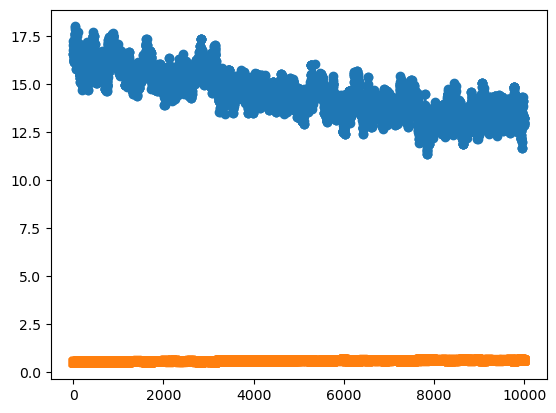

In [141]:
loss_coords, accuracy_coords = feed_forward(new3, labels, num_iters=10000)

In [142]:
#replace sigmoid w soft max
#one hot output 
#sepearte weights for each category: colors
#change to categorical cross entroy